In [1]:
import pandas as pd
from sklearn.cluster import Birch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.style as style
import numpy as np

# Read file into dataframe
df = pd.read_csv('animals.csv')

# Drop rows with 50% or more null values
df.dropna(axis = 0, thresh = len(df.columns)/2, inplace=True)
df.shape


(342, 10)

In [2]:
df.head()

,Region,Stage,Individual ID,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,Anvers,"Adult, 1 Egg Stage",N1A1,39.1,18.7,181.0,3750.0,NaN,NaN,Not enough blood for isotopes.
1,Anvers,"Adult, 1 Egg Stage",N1A2,39.5,17.4,186.0,3800.0,8.94956,-24.69454,NaN
2,Anvers,"Adult, 1 Egg Stage",N2A1,40.3,18.0,195.0,3250.0,8.36821,-25.33302,NaN
4,Anvers,"Adult, 1 Egg Stage",N3A1,36.7,19.3,193.0,3450.0,8.76651,-25.32426,NaN
5,Anvers,"Adult, 1 Egg Stage",N3A2,39.3,20.6,190.0,3650.0,8.66496,-25.29805,NaN


In [3]:
# Impute missing values using the mean
mean_impute = SimpleImputer(strategy='mean')
mean_impute.fit(df[['Delta 15 N (o/oo)','Delta 13 C (o/oo)']])
df[['Delta 15 N (o/oo)','Delta 13 C (o/oo)']] = mean_impute.transform(df[['Delta 15 N (o/oo)','Delta 13 C (o/oo)']])

# Standardize all numeric columns
X = df._get_numeric_data()
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Birch Model Hyperparameters:
* **Threshold** – The maximum number of data samples to be considered in a subcluster of the leaf node in a CF tree. <br/><br/>
* **Branching_factor** – Specifies the number of CF sub-clusters that can be made in a node <br/><br/>
* **N_clusters** – Number of clusters <br/><br/>

In [4]:
# We let Birch choose optimal number of clusters by setting n_clusters = None to see what it chooses
bm = Birch(branching_factor = 50, n_clusters = None, threshold = 1)
bm.fit(X)
pred = bm.predict(X);

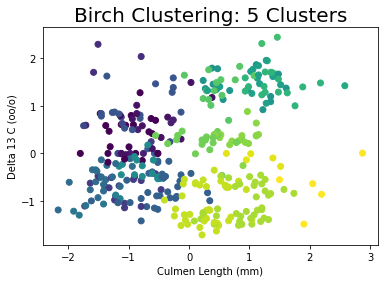

In [5]:
# We see it chooses 5 as the optimal number of clusters when none are specified
plt.scatter(X[:, 0], X[:, 5], c = pred)
plt.xlabel('Culmen Length (mm)') 
plt.ylabel('Delta 13 C (oo/o)');
plt.title('Birch Clustering: 5 Clusters',fontsize=20);

In [6]:
# Grid Search for Best Parameters
gridresults = pd.DataFrame(columns = ['Silhouette', 'Threshold', 'Clusters', 'BranchFactor'])

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
range_threshold =  [0.2,0.4,0.6,0.8,1,1.2,1.4]
range_branch = [10,50,100,200,500,1000]

for cluster in range_n_clusters:
    for thresh in range_threshold:
        for branch in range_branch:
            
            # Initialise Birch Model
            bm = Birch(branching_factor = branch, n_clusters = cluster, threshold = thresh)
            bm.fit(X)
            cluster_labels = bm.labels_
            
            # Store Results with Silhouette Score
            gridresults = pd.concat([gridresults, pd.DataFrame.from_records([{'Silhouette':silhouette_score(X, cluster_labels),
                                              'Threshold':thresh,
                                              'Clusters':cluster,
                                              'BranchFactor':branch}])], ignore_index=True) 


gridresults.sort_values(by = 'Silhouette', ascending = False, inplace = True)
gridresults.reset_index(drop = True, inplace = True)

# Obtain optimized Hyper Parameters 
tunedThreshold = gridresults['Threshold'][0];
tunedClusters = gridresults['Clusters'][0];
tunedBranch = gridresults['BranchFactor'][0];

# Print out optimal Hyper Parameters
print(f'Optimal Threshold: {tunedThreshold}\nOptimal Num Clusters: {int(tunedClusters)} \nOptimal Branch Factor: {int(tunedBranch)}')

Optimal Threshold: 0.2
Optimal Num Clusters: 2 
Optimal Branch Factor: 10


### How is Optimal Number of Clusters being determined? 

Silhouette Score is calculated as:

$$s_i = \frac{b_i - a_i}{max\{a_i, b_i\}}$$

Where:

* $a_i$ = Average distance from point $x_i$ to all other points **in the same cluster**.
* $b_i$ = Smallest mean distance from point $x_i$ to all points **in any other cluster**.

And the resulting silhouette score is the **average** of all the scores:

* **Value of 1** = Sample is far away from neighboring clusters <br/> <br/>
* **Value of 0** = Sample is on or very close to the decision boundary between neighboring clusters <br/> <br/>
* **Value of -1** = Sample may have been classified into the wrong cluster <br/> <br/>

The silhouette score evaluates the viability of your clusters. It is a way to quantify the "cohesion" of local points to their clusters and the separation to other clusters.

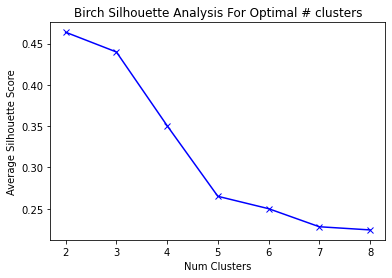

In [7]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
 # initialise birch
    bm = Birch(n_clusters=num_clusters, branching_factor=30)
    bm.fit(X)
    cluster_labels = bm.labels_
 
 # silhouette score
    silhouette_avg.append(silhouette_score(X, cluster_labels))
    

plt.plot(range_n_clusters, silhouette_avg,'bx-')
plt.xlabel('Num Clusters') 
plt.ylabel('Average Silhouette Score') 
plt.title('Birch Silhouette Analysis For Optimal # clusters')
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.4638
For n_clusters = 3, the average silhouette_score is : 0.4387
For n_clusters = 4, the average silhouette_score is : 0.3515
For n_clusters = 5, the average silhouette_score is : 0.2624
For n_clusters = 6, the average silhouette_score is : 0.2612


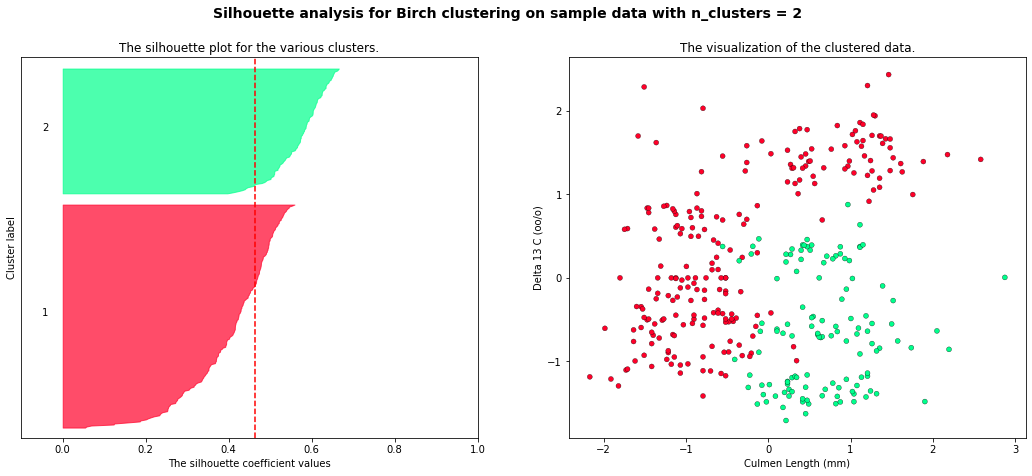

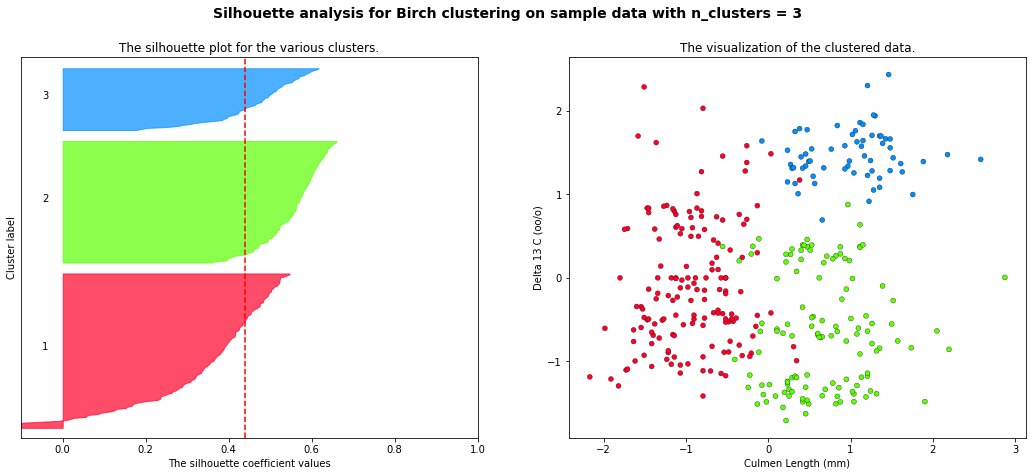

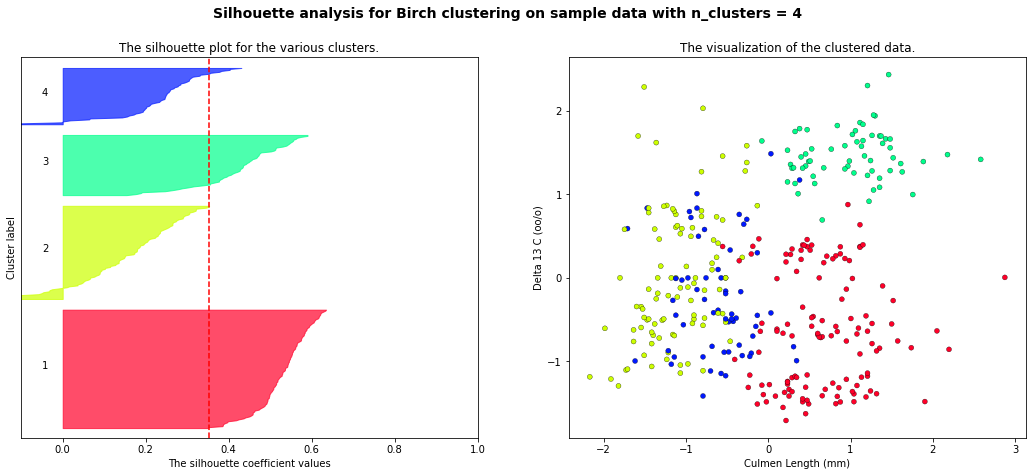

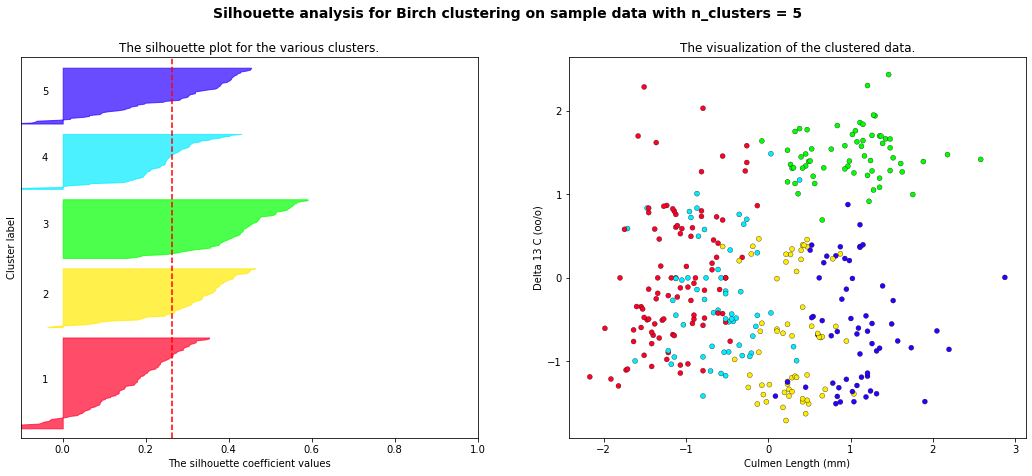

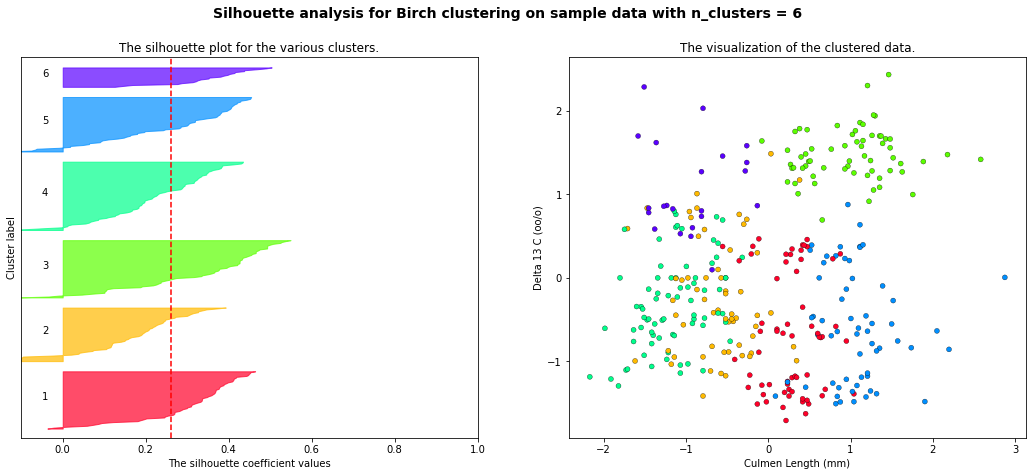

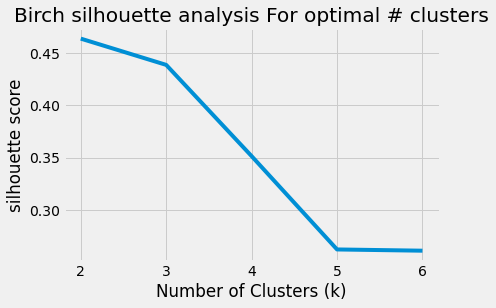

In [8]:
range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg_n_clusters = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and the optimized hyperparameter found from the Grid Search
    clusterer = Birch(n_clusters=n_clusters, branching_factor = int(tunedBranch), threshold = tunedThreshold)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg:.4f}")

    silhouette_avg_n_clusters.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.gist_rainbow(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.gist_rainbow(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 5], marker='.', s=100, lw=0.3,
                c=colors, edgecolor='k')
    

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Culmen Length (mm)")
    ax2.set_ylabel("Delta 13 C (oo/o)")

    plt.suptitle(("Silhouette analysis for Birch clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()
style.use("fivethirtyeight")
plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("silhouette score")
plt.title('Birch silhouette analysis For optimal # clusters')
plt.show()